#### Libraries

In [83]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

#### Get The Testing Data Set Up

In [2]:
data = pd.read_csv('Resources/US_Data.csv')
data.head()

,Unnamed: 0,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470.0,1.0,75.988020,21583.0,437.0,2.610160,84000001.0,USA,460.300152,12.264945
1,1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,8038.0,31.0,2.941176,84000002.0,USA,1344.711576,11.397059
2,2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,4.0,48.662422,42109.0,NaN,3.246753,84000004.0,USA,578.522286,NaN
3,3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,19722.0,130.0,2.109375,84000005.0,USA,761.753354,10.156250
4,4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155.0,6.0,58.137726,190328.0,5234.0,2.812020,84000006.0,USA,485.423869,22.961176


In [3]:
usa = data.groupby('Last_Update').sum()
usa = usa.drop(columns=['Lat', 'Long_', 'Unnamed: 0'])
usa.head()

,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,Testing_Rate,Hospitalization_Rate
Last_Update,,,,,,,,,,,,
2020-04-12 23:18:15,555262,22018,34108.0,533244.0,3571.0,7349.862704,2805539.0,92248.0,179.129862,4.452192e+09,52305.870218,698.013149
2020-04-13 23:07:54,559600,23029,35442.0,536571.0,190637.0,7645.721482,2738796.0,89969.0,180.542529,4.368193e+09,54681.645813,713.066489
2020-04-14 00:42:00,21019,499,0.0,122520.0,12.0,579.387193,196207.0,2833.0,0.405628,8.400001e+07,924.083459,2.302896
2020-04-14 23:33:31,607670,25831,37645.0,581839.0,190649.0,8144.137345,3081617.0,101017.0,191.648208,4.452193e+09,58222.456982,752.083044
2020-04-15 22:56:51,636350,28325,39405.0,608025.0,190649.0,8520.747540,3242752.0,103839.0,196.366401,4.452193e+09,61138.422190,743.813574


In [77]:
X = usa.index.values.reshape(-1, 1) # These will be the dates
y = usa[["Confirmed", "Deaths"]]

counter = 0;

# Might as well convert to 'days from first record date' to avoid datatype
# issues
for item in X:
    item[0] = counter
    counter += 1
print(X.shape, y.shape)

(127, 1) (127, 2)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_x.transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print(f"Scalers: {scaler_x}, {scaler_y}")

Scalers: StandardScaler(), StandardScaler()


### Analysis

In [105]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
print(model.score(X_test_scaled, y_test_scaled))

0.9330125597231458


In [106]:
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.07607438645206566, R2: 0.9330125597231458


### Displaying items

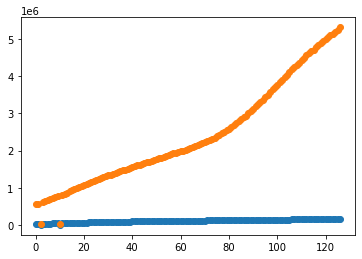

In [107]:
scatter_day = range(usa.count().min())
scatter_deaths = []
scatter_cases = []

for i in scatter_day:
    scatter_deaths.append(usa['Deaths'][i])
    scatter_cases.append(usa['Confirmed'][i])

plt.scatter(scatter_day, scatter_deaths)
plt.scatter(scatter_day, scatter_cases)

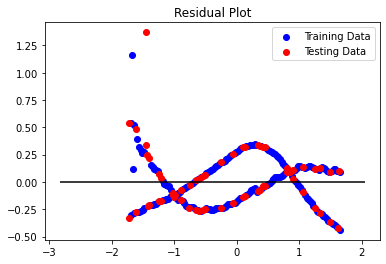

In [108]:
plt.scatter((model.predict(X_train_scaled)), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="red", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()